# Training IRLC


In [0]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [0]:
from google.colab import files
uploaded = files.upload()

Saving dataset.py to dataset.py


In [0]:
!rm  dataset.py

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from torch.autograd import Variable

from dataset import Dictionary, HMQAFeatureDataset
from model import SoftCount
from config import *
from datetime import datetime, timedelta

import h5py
import numpy as np
import _pickle as pkl
import json
import torch.nn.functional as F
import numpy as np
import _pickle as pkl
import json
import h5py
from dataset import Dictionary
from PIL import Image # to load
from IPython.display import display # to display
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [0]:
dictionary = Dictionary.load_from_file('data/dictionary.pkl')
train_h5_loc = './data/train36.hdf5'
with h5py.File(train_h5_loc, 'r') as hf:
    train_image_features = np.array(hf.get('image_features')[0:10000])
    train_spatials_features = np.array(hf.get('spatial_features')[0:10000])

loading dictionary from data/dictionary.pkl


In [0]:
from dataset import HMQAFeatureDataset

hmqa_train_dset = HMQAFeatureDataset(
    img_id2hqma_idx = pkl.load(open("./data/train36_imgid2idx.pkl", "rb")),
    image_features = train_image_features, 
    spatial_features = train_spatials_features, 
    qid2count = json.load(open("./data/how_many_qa/qid2count.json", "rb")), 
    qid2count2score = json.load(open("./data/how_many_qa/qid2count2score.json", "rb")), 
    name="train", 
    dictionary=dictionary
)
del HMQAFeatureDataset

In [0]:
val_h5_loc = './data/val36.hdf5'
with h5py.File(val_h5_loc, 'r') as hf:
    val_image_features = np.array(hf.get('image_features')[0:5000])
    val_spatials_features = np.array(hf.get('spatial_features')[0:5000])

In [0]:
from dataset import HMQAFeatureDataset

hmqa_dev_dset = HMQAFeatureDataset(
    img_id2hqma_idx = pkl.load(open("./data/val36_imgid2idx.pkl", "rb")),
    image_features = val_image_features, 
    spatial_features = val_spatials_features, 
    qid2count = json.load(open("./data/how_many_qa/qid2count.json", "rb")), 
    qid2count2score = json.load(open("./data/how_many_qa/qid2count2score.json", "rb")), 
    name="dev", 
    dictionary=dictionary
)

hmqa_test_dset = HMQAFeatureDataset(
    img_id2hqma_idx = pkl.load(open("./data/val36_imgid2idx.pkl", "rb")),
    image_features = val_image_features, 
    spatial_features = val_spatials_features, 
    qid2count = json.load(open("./data/how_many_qa/qid2count.json", "rb")), 
    qid2count2score = json.load(open("./data/how_many_qa/qid2count2score.json", "rb")), 
    name="test", 
    dictionary=dictionary
)
del HMQAFeatureDataset

In [0]:
from torch.utils.data import DataLoader

hmqa_train_loader = DataLoader(hmqa_train_dset, 64, shuffle=True, num_workers=0)
hmqa_dev_loader = DataLoader(hmqa_dev_dset, 64, shuffle=True, num_workers=0)
hmqa_test_loader = DataLoader(hmqa_test_dset, 64, shuffle=True, num_workers=0)

In [0]:

def evaluate(model, hmqa_loader):
    
    all_acc = []
    all_se = []
    for i, (v_emb, b, q, c, c2s) in enumerate(hmqa_loader):
        v_emb = Variable(v_emb)
        b = Variable(b)
        q = Variable(q)
        c = Variable(c).view(-1).float()
        
        if USE_CUDA:
            v_emb = v_emb.cuda()
            b = b.cuda()
            q = q.cuda()
            c = c.cuda()
        
        kappa_0, rho = model.compute_vars(v_emb, b, q)
        count, greedy_count, logPA, entP, A, rho, P = model.take_mc_samples(kappa_0, rho, 1)
        
#         pred = model(v_emb, q)
        
#         ret = torch.stack((count.float(), greedy_count.float(), c.float()))
#         break
    
        nearest_pred = (greedy_count + 0.5).long().clamp(0, 20)
        for one_c, one_c2s, one_pred in zip(c, c2s, nearest_pred):
            one_c = one_c.cpu().data
            one_pred = one_pred.cpu().data
            
#             print("one_c = ", one_c, " and nearest pred = ", one_pred)
            
            all_se.append((one_c - one_pred.float()) ** 2)
            all_acc.append(one_c2s[one_pred])
    
    acc = torch.stack(all_acc).mean()
    rmse = torch.stack(all_se).mean() ** 0.5
    
    return acc, rmse  #, ret

In [0]:
def isnan(x):
    check = (x != x)
    check = check.float().sum().data[0]
    return check > 0

In [0]:
from model import IRLC
model = IRLC(dropout=0.5)
del IRLC
if USE_CUDA:
    model.cuda()
model

initialising with glove embeddings
 self.word_dim is  torch.Size([28333, 300])
done.


IRLC(
  (ques_parser): QuestionParser(
    (embd): Embedding(28334, 300, padding_idx=28333)
    (rnn): GRU(300, 1024)
    (drop): Dropout(p=0)
  )
  (f_s): ScoringFunction(
    (v_drop): Dropout(p=0.5)
    (q_drop): Dropout(p=0.5)
    (v_proj): FCNet(
      (main): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (q_proj): FCNet(
      (main): Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (s_drop): Dropout(p=0.5)
  )
  (W): Linear(in_features=2048, out_features=1, bias=True)
  (f_rho): RhoScorer(
    (W): Linear(in_features=1024, out_features=1, bias=True)
    (f_rho): FCNet(
      (main): Sequential(
        (0): Linear(in_features=17, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (dense): Linear(in_features=100, out_features=1, bias=True)
  )
  (extra_pa

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=.99)

In [0]:
test_acc, test_rmse = evaluate(model, hmqa_test_loader)
test_acc, test_rmse

In [0]:
test_accs = []
test_rmses = []
dev_accs = []
dev_rmses = []
exp_name = "hope-2048-0.5-ques0"

In [0]:
for epoch in range(0, 10):
    # adjust learning rate
    sched.step()
    print("learning rate is {}".format(opt.param_groups[0]["lr"]))
    
    for i, (v_emb, b, q, c, _) in enumerate(hmqa_train_loader):
        v_emb = Variable(v_emb)
        b = Variable(b)
        q = Variable(q)
        c = Variable(c).view(-1).float()

        if USE_CUDA:
            v_emb = v_emb.cuda()
            q = q.cuda()
            c = c.cuda()
            b = b.cuda()

        B, k, _ = v_emb.size()

        kappa_0, rho = model.compute_vars(v_emb, b, q)

        num_samples = 5
        count, greedy_count, logPA, entP, A, rho, P = model.take_mc_samples(kappa_0, rho, num_samples)
        c_gt = torch.cat([c] * num_samples)

        loss = model.get_loss(c_gt, count, greedy_count, logPA, entP, A, rho)

        if i % 100 == 0:
            print("epoch = {}, i = {}, loss = {},".format(epoch, i, loss.data.item(),))

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)
        opt.step()


    print("evaluating model on dev and test...")

    model.eval()
    dev_acc, dev_rmse = evaluate(model, hmqa_dev_loader)
    print("dev_acc: {}, dev_rmse: {}".format(dev_acc, dev_rmse))
    test_acc, test_rmse = evaluate(model, hmqa_test_loader)
    print("test_acc: {}, test_rmse: {}".format(test_acc, test_rmse))
    model.train()
    
    if dev_acc<dec_accs[epoch-1]:
      print("Early Stop")
      break
    
    test_accs.append(test_acc)
    test_rmses.append(test_rmse)
    dev_accs.append(dev_acc)
    dev_rmses.append(dev_rmse)

learning rate is 0.000495
epoch = 0, i = 0, loss = 35.75075149536133,


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


epoch = 0, i = 100, loss = -0.11333845555782318,
epoch = 0, i = 200, loss = -0.03442147374153137,
epoch = 0, i = 300, loss = -0.08350008726119995,
epoch = 0, i = 400, loss = 0.007305945735424757,
epoch = 0, i = 500, loss = 0.0035721443127840757,
epoch = 0, i = 600, loss = 0.004236831795424223,
epoch = 0, i = 700, loss = -0.0060684047639369965,
evaluating model on dev and test...
dev_acc: 0.31884393095970154, dev_rmse: 3.7677509784698486
test_acc: 0.33111995458602905, test_rmse: 3.5773732662200928
learning rate is 0.00049005
epoch = 1, i = 0, loss = 0.016632821410894394,
epoch = 1, i = 100, loss = -0.045296281576156616,
epoch = 1, i = 200, loss = -0.03334367275238037,
epoch = 1, i = 300, loss = -0.0022083972580730915,
epoch = 1, i = 400, loss = -0.021028069779276848,
epoch = 1, i = 500, loss = -0.007932889275252819,
epoch = 1, i = 600, loss = -0.00491581903770566,
epoch = 1, i = 700, loss = 0.01726692169904709,
evaluating model on dev and test...
dev_acc: 0.34061771631240845, dev_rmse: 

In [0]:
top_dev_accs = sorted(zip(dev_accs, test_accs, test_rmses), reverse=True)
best_dev_acc, corr_test_acc, corr_test_rmse = top_dev_accs[0]
print("The best dev accuracy is {}. The corresponding test accuracy and test RMSE are {} and {} respectively".format(
    best_dev_acc, corr_test_acc, corr_test_rmse
))

The best dev accuracy is 0.35385584831237793. The corresponding test accuracy and test RMSE are 0.3330199718475342 and 3.194213628768921 respectively


# Prepare to see the performance of model

In [0]:
class DummyLoader:
    mode = "train"
    def __init__(self):
        self.h5_loc = "./data/{}36.hdf5".format(self.mode)
        self.question_path = './data/v2_OpenEnded_mscoco_{}2014_questions.json'.format(self.mode)
        self.imgid2idx_loc = "./data/{}36_imgid2idx.pkl".format(self.mode)
        
        self.qid2count = json.load(open("./data/how_many_qa/qid2count.json", "rb"))["train"]["vqa"]
        self.dictionary = Dictionary.load_from_file('data/dictionary.pkl')
        self.imgid2idx = pkl.load(open(self.imgid2idx_loc, "rb"))
        self.questions = sorted(json.load(open(self.question_path))['questions'], key=lambda x: x['question_id'])
        
        self.valid_qids = set(self.qid2count.keys())
        self.questions = [entry for entry in self.questions if str(entry["question_id"]) in self.valid_qids]
        
        
    def tokenize(self, question, max_length=14):
        """Tokenizes the questions.

        This will add q_token in each entry of the dataset.
        -1 represent nil, and should be treated as padding_idx in embedding
        """
        tokens = self.dictionary.tokenize(question, False)
        tokens = tokens[:max_length]
        if len(tokens) < max_length:
            # Note here we pad in front of the sentence
            padding = [self.dictionary.padding_idx] * (max_length - len(tokens))
            tokens = padding + tokens
        assert len(tokens) == max_length
        return tokens
    
    def get_image_features(self, idx):
        with h5py.File(self.h5_loc, 'r') as hf:
            v = hf["image_features"][idx]
            b = hf["spatial_features"][idx]
        return v, b  # (k, 2048), (k, 6)
    
    def show_entry(self, idx):
        entry = self.questions[idx]
        question = entry["question"]
        image_coco_id = entry["image_id"]
        image_loc = 'data/train2014/train2014/COCO_train2014_%012d.jpg' % image_coco_id
#         image = Image(filename=image_loc)
        gt_count = self.qid2count[str(entry["question_id"])]
        return question, gt_count, image_loc
    
    def get_entry(self, idx):
        
        entry = self.questions[idx]
        q = self.tokenize(entry['question'])
        image_coco_id = entry["image_id"]
        img_idx = self.imgid2idx[image_coco_id]
        v, b = self.get_image_features(img_idx)
        
        q = torch.from_numpy(np.array(q))[None]
        v = torch.from_numpy(np.array(v))[None]
        b = torch.from_numpy(np.array(b))[None]
        
        return q, v, b

In [0]:
dl = DummyLoader()

loading dictionary from data/dictionary.pkl


In [0]:
model.eval()

IRLC(
  (ques_parser): QuestionParser(
    (embd): Embedding(28334, 300, padding_idx=28333)
    (rnn): GRU(300, 1024)
    (drop): Dropout(p=0)
  )
  (f_s): ScoringFunction(
    (v_drop): Dropout(p=0.5)
    (q_drop): Dropout(p=0.5)
    (v_proj): FCNet(
      (main): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (q_proj): FCNet(
      (main): Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (s_drop): Dropout(p=0.5)
  )
  (W): Linear(in_features=2048, out_features=1, bias=True)
  (f_rho): RhoScorer(
    (W): Linear(in_features=1024, out_features=1, bias=True)
    (f_rho): FCNet(
      (main): Sequential(
        (0): Linear(in_features=17, out_features=100, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (dense): Linear(in_features=100, out_features=1, bias=True)
  )
  (extra_pa

In [0]:
def draw_box_probs(img_loc, box_probs=None, selected_boxes=None):
#     im = np.array(Image.open('data/train2014/train2014/COCO_train2014_%012d.jpg' % 9), dtype=np.uint8)
    im = np.array(Image.open(img_loc), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Display the image
    ax.imshow(im)
    h, w, _ = im.shape
    
    if box_probs is not None:
        for box, prob in box_probs:
            x = box[0] * w
            y = box[1] * h
            x_w = box[4] * w
            y_w = box[5] * h

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), x_w, y_w,linewidth=2,edgecolor='b',facecolor='none', alpha=prob)

            # Add the patch to the Axes
            ax.add_patch(rect)
    
    if selected_boxes is not None:
        for box, _ in selected_boxes:
            x = box[0] * w
            y = box[1] * h
            x_w = box[4] * w
            y_w = box[5] * h

            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), x_w, y_w,linewidth=2,edgecolor='r',facecolor='none', alpha=1)

            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()

In [0]:
def visualize(idx):
    q, v, b = dl.get_entry(idx)
    if USE_CUDA:
            v = v.cuda()
            q = q.cuda()
            b = b.cuda()
    kappa_0, rho = model.compute_vars(v, b, q)
    count, greedy_count, logPA, entP, A, rho, P = model.take_mc_samples(kappa_0, rho, 1)
    P = P[:, 0, :]
    A = A[:, 0]
    ques, gt_count, image_loc = dl.show_entry(idx)
      
    print("ques: {}".format(ques))
    print("ans: {}".format(gt_count))
    print("pred: {}".format(count))
    
    draw_box_probs(image_loc)

    cands = zip(b[0], 0 * P[0] + 1)
    draw_box_probs(image_loc, cands)
    sels = []
    for t in range(0, 36):
        cands = zip(b[0], P[t])
        draw_box_probs(image_loc, cands, sels)

        selection = A[t]
        if selection == 36:
            break
        sels.append((b[0][selection], None))
        
    return

In [0]:
def SeePic(idx1,idx2,idx3,idx4):
  ques, gt_count, image_loc = dl.show_entry(idx)
  print("ques: {}".format(ques))
  print("ans: {}".format(gt_count))
  im = np.array(Image.open(image_loc), dtype=np.uint8)
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  return 

# Let's see some questions, answers and pictures!

ques: How many keyboards are in the picture?
ans: 2


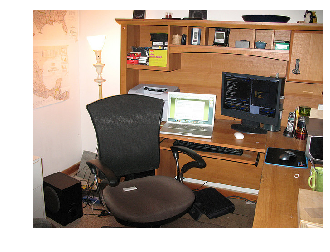

In [0]:
SeePic(503)

ques: How many people are in the boat?
ans: 1


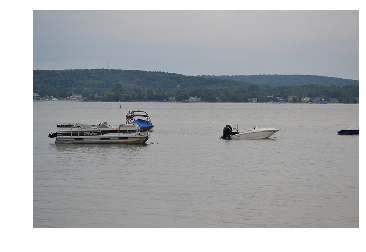

In [0]:
SeePic(533)

ques: How many giraffe are walking across the field?
ans: 3


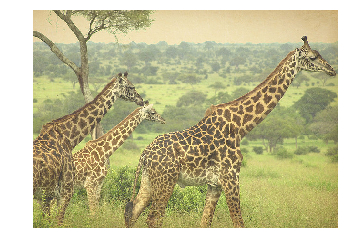

In [0]:
SeePic(2342)

# Let's see some predictions of the model!

ques: How many tracks are there?
ans: 2
pred: tensor([2], device='cuda:0')


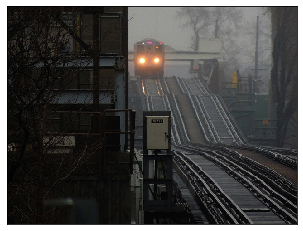

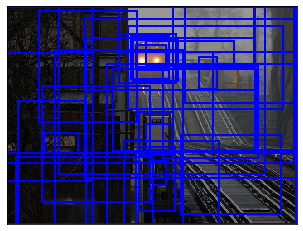

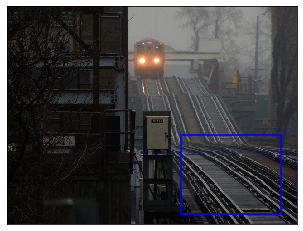

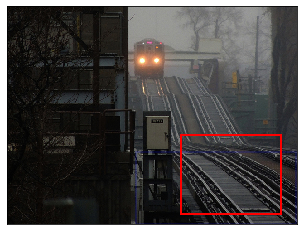

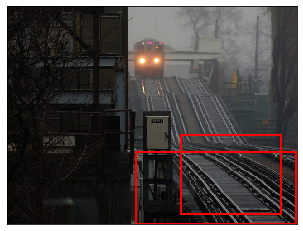

In [0]:
visualize(507)

ques: How many bird are seen?
ans: 1
pred: tensor([1], device='cuda:0')


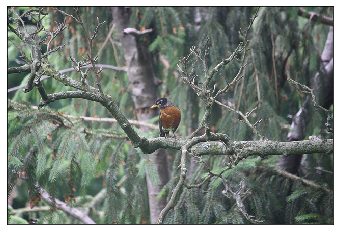

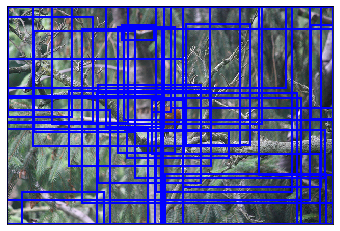

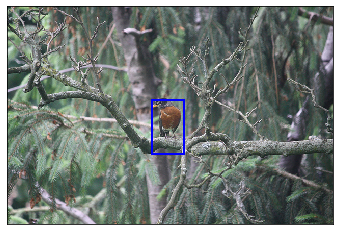

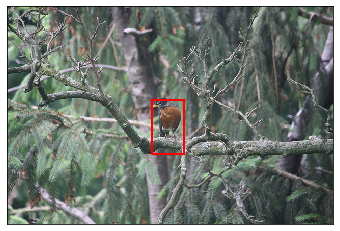

In [0]:
visualize(1538)

ques: How many giraffes are there?
ans: 1
pred: tensor([1], device='cuda:0')


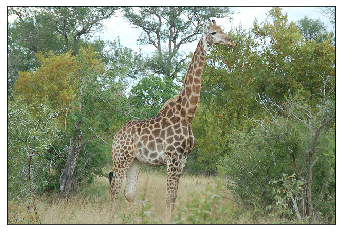

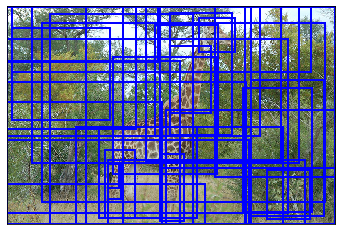

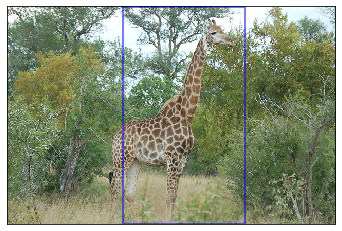

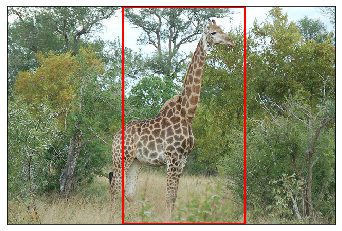

In [0]:
visualize(840)

ques: How many people is in the picture?
ans: 1
pred: tensor([1], device='cuda:0')


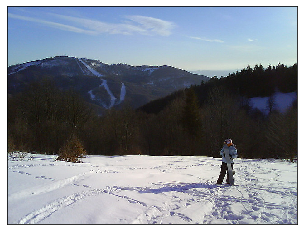

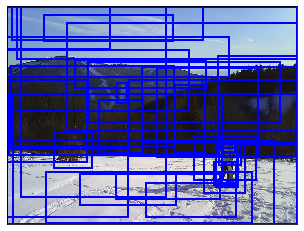

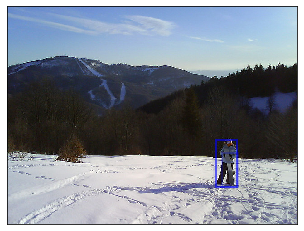

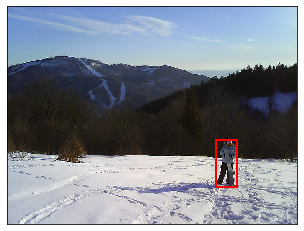

In [0]:
visualize(880)

ques: How many chairs are there?
ans: 1
pred: tensor([1], device='cuda:0')


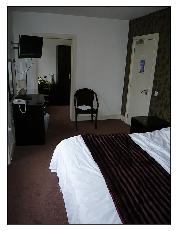

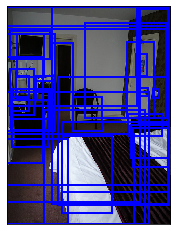

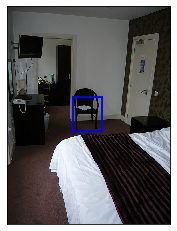

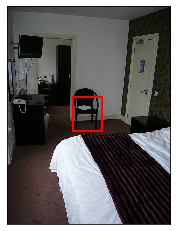

In [0]:
visualize(1085)

ques: How many sheep?
ans: 3
pred: tensor([3], device='cuda:0')


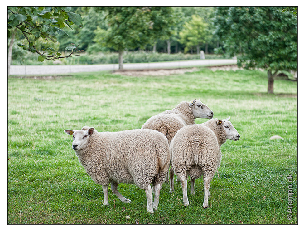

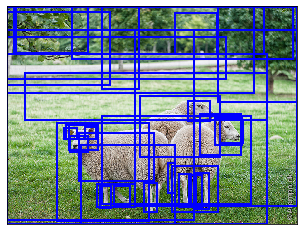

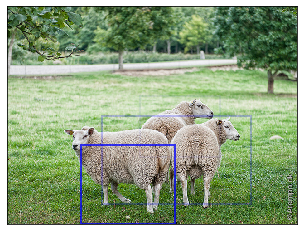

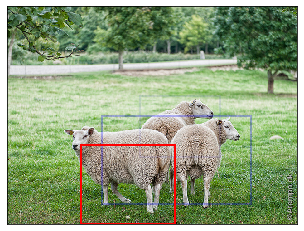

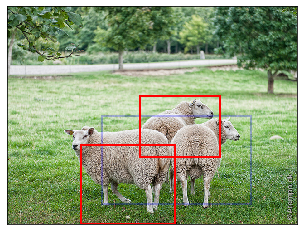

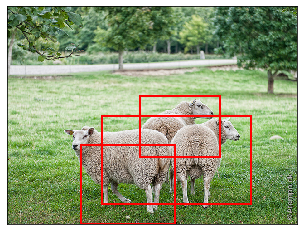

In [0]:
visualize(2458)

In [0]:
visualize(2300)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
time=0
for i in range(2400,3000):
  a=findnum(i)
  if a==True:
    time+=1
    visualize(i)
  if time==50:
    break

ques: How many blue suitcases are there?
ans: 1
pred: tensor([1], device='cuda:0')


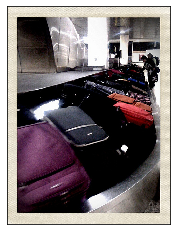

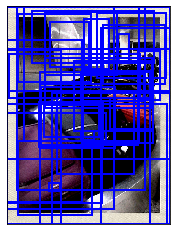

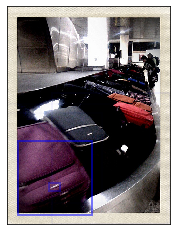

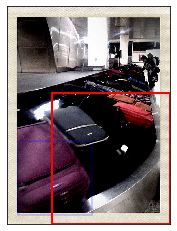

In [0]:
visualize(330)

ques: How many animals are in the picture?
ans: 1
pred: tensor([0], device='cuda:0')


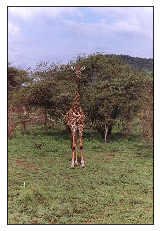

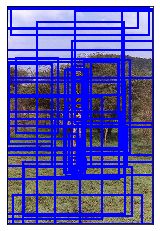

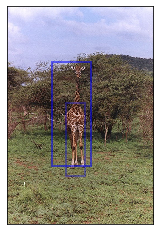

In [0]:
visualize(2249)

ques: How many animals are in the field?
ans: 2
pred: tensor([2], device='cuda:0')


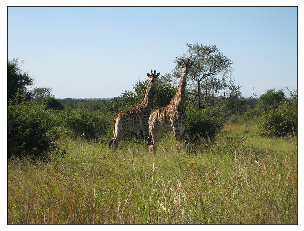

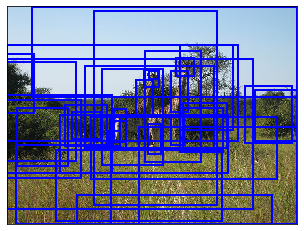

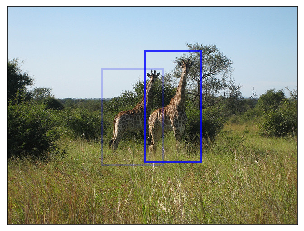

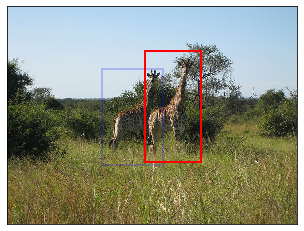

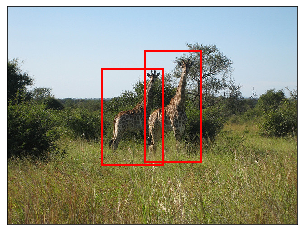

In [0]:
visualize(2290)

ques: How many people?
ans: 2
pred: tensor([2], device='cuda:0')


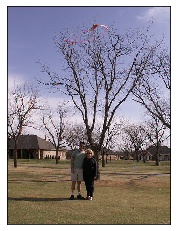

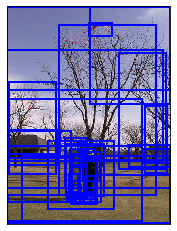

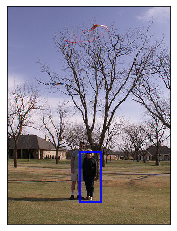

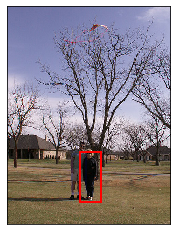

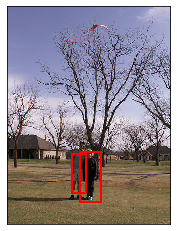

In [0]:
visualize(2064)

ques: How many trees are in this picture?
ans: 0
pred: tensor([0], device='cuda:0')


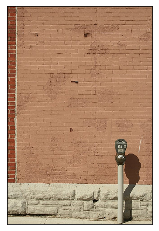

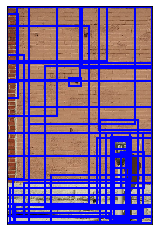

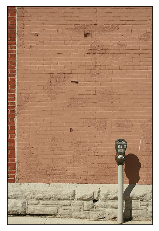

In [0]:
visualize(999)